In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [4]:
data = train.copy()

data = data.append(test)

data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


- **Kategorik değişkenkeri** ve bizim belirlediğimiz sayının altında benzersiz veriye sahip değişkenleri alalım.

- **Ordinal Değişkenler** ; Ordinal veriler de yine kategorik veri türündendir. Fakat değerleri arasında sıralı bir ilişki bulunmaktadır.

- Bu değişkenleri veren bir fonksiyon yazalım.

In [5]:
def Feature_Names(df,cat_num, car_num,show = False):
    
    #Date cols
    date_cols = [cols for cols in df.columns if df[cols].dtypes == 'datetime64[ns]']
    
    #Kategorik Değişkenler
    cat_cols = [cols for cols in df.columns if df[cols].dtypes == 'object']
       
    #Numerik Ama Kategorik Değişkenler    
    num_but_cat = [cols for cols in df.columns if df[cols].dtypes != 'object'
                  and df[cols].nunique() < int(cat_num) and df[cols].dtypes != 'datetime64[ns]'] 
        
    #Kategorik Ama Kardinal
    cat_but_car = [cols for cols in df.columns if df[cols].dtypes == 'object' 
                  and df[cols].nunique() > int(car_num)]
    
    cat_cols = cat_cols + num_but_cat 
    
    cat_cols = [cols for cols in cat_cols if cols  not in cat_but_car]
        
    num_cols = [cols for cols in df.columns if df[cols].dtypes != 'object'
               and cols not in num_but_cat]
    
    print(f"Date Columns : {len(date_cols)}")
    print(f"Cat Columns : {len(cat_cols)}")
    print(f"Cat But Car : {len(cat_but_car)}")
    print(f"Num But Cat : {len(num_but_cat)}")
    print(f"Num Cols : {len(num_cols)}")
        
    if show:
        
        return date_cols,cat_cols,cat_but_car,num_cols,num_but_cat
    else:
        
        cat_cols,cat_but_car,num_cols,num_but_cat
    
Feature_Names(data,cat_num=10, car_num = 10)    

Date Columns : 0
Cat Columns : 50
Cat But Car : 3
Num But Cat : 10
Num Cols : 28


# Kategorik Değişkenler 

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

- Kategorik Değişkenlerimizi alalım 

In [7]:
def Cat_Cols(df):
    
    cat_cols = [cols for cols in df.columns if df[cols].dtype == 'object']
    
    for cols in cat_cols:
        
        data_new = pd.DataFrame({cols:df[cols].value_counts(),'Oran':df[cols].value_counts() / len(df)})
        
        print(f"#######################################################")
        print(data_new, end = "\n\n")

Cat_Cols(data)    

#######################################################
         MSZoning      Oran
RL           2265  0.775951
RM            460  0.157588
FV            139  0.047619
RH             26  0.008907
C (all)        25  0.008565

#######################################################
      Street      Oran
Pave    2907  0.995889
Grvl      12  0.004111

#######################################################
      Alley      Oran
Grvl    120  0.041110
Pave     78  0.026721

#######################################################
     LotShape      Oran
Reg      1859  0.636862
IR1       968  0.331620
IR2        76  0.026036
IR3        16  0.005481

#######################################################
     LandContour      Oran
Lvl         2622  0.898253
HLS          120  0.041110
Bnk          117  0.040082
Low           60  0.020555

#######################################################
        Utilities      Oran
AllPub       2916  0.998972
NoSeWa          1  0.000343

################

- Numeric Ama Kategorik olan değişkenlerimizi alacağız.
- Benzersiz verileri 10'dan küçük olan Değişkenleri alacağız.
- Değişkenlerimizin Benzersiz verilerinin toplam Data sayımıza oranını bulucağız
- Değişkenlerimizi görselleştireceğiz.
- Bu hepsini bize veren bir fonskiyon yazacağız.

In [8]:
import matplotlib.pyplot as plt

######################################################
   OverallCond      Oran
5         1645  0.563549
6          531  0.181912
7          390  0.133607
8          144  0.049332
4          101  0.034601
3           50  0.017129
9           41  0.014046
2           10  0.003426
1            7  0.002398


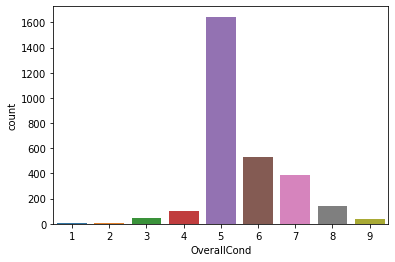

######################################################
     BsmtFullBath      Oran
0.0          1705  0.584104
1.0          1172  0.401507
2.0            38  0.013018
3.0             2  0.000685


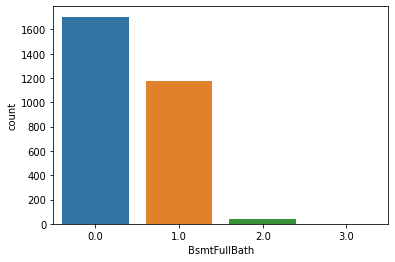

######################################################
     BsmtHalfBath      Oran
0.0          2742  0.939363
1.0           171  0.058582
2.0             4  0.001370


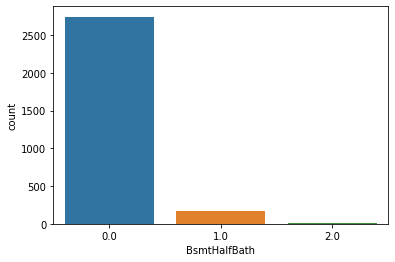

######################################################
   FullBath      Oran
2      1530  0.524152
1      1309  0.448441
3        64  0.021925
0        12  0.004111
4         4  0.001370


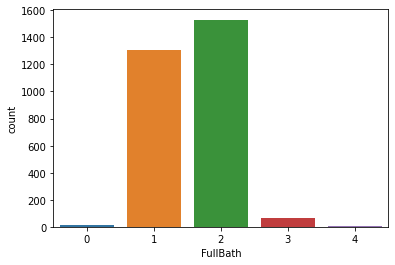

######################################################
   HalfBath      Oran
0      1834  0.628297
1      1060  0.363138
2        25  0.008565


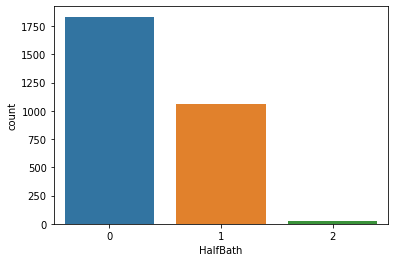

######################################################
   BedroomAbvGr      Oran
3          1596  0.546763
2           742  0.254197
4           400  0.137033
1           103  0.035286
5            48  0.016444
6            21  0.007194
0             8  0.002741
8             1  0.000343


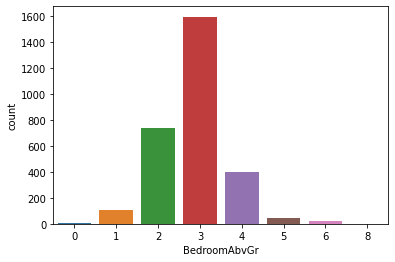

######################################################
   KitchenAbvGr      Oran
1          2785  0.954094
2           129  0.044193
0             3  0.001028
3             2  0.000685


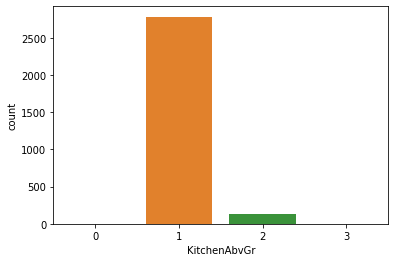

######################################################
   Fireplaces      Oran
0        1420  0.486468
1        1268  0.434395
2         219  0.075026
3          11  0.003768
4           1  0.000343


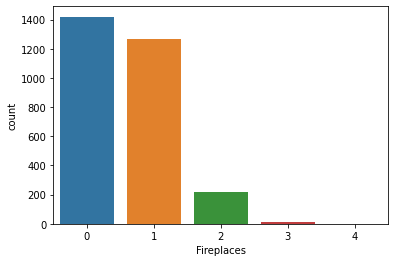

######################################################
     GarageCars      Oran
2.0        1594  0.546077
1.0         776  0.265844
3.0         374  0.128126
0.0         157  0.053786
4.0          16  0.005481
5.0           1  0.000343


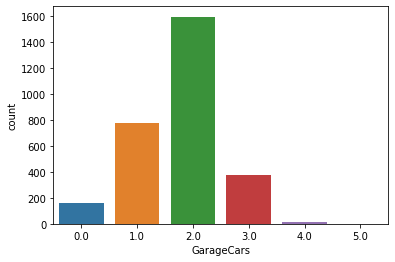

######################################################
      YrSold      Oran
2007     692  0.237067
2009     647  0.221651
2008     622  0.213087
2006     619  0.212059
2010     339  0.116136


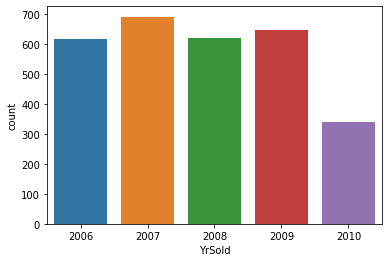

In [9]:
def Num_Cat_Cols(df, cat_number, plot = False):
        
    num_cat = [cols for cols in df.columns if df[cols].nunique() < int(cat_number)
              and df[cols].dtype != 'object']
        
    for cols in num_cat:
               
        print(f"######################################################") 
        data_new = pd.DataFrame({cols:df[cols].value_counts(),'Oran':df[cols].value_counts() / len(df)})
        print(data_new, end = "\n")
        
        if plot:
            
            sns.countplot(x=cols, data=df)
            plt.show()

Num_Cat_Cols(data, cat_number = 10, plot=True)

# Sayısal Değer

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,2919.0,1460.000000,842.787043,1.0,730.5,1460.0,2189.5,2919.0
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.0,368.5,733.0,5644.0


- Numeric yani Sayısal Değişkenlerimizi alacağız.
- Değişkenlerimizin Histogram görselleştireceğiz.

######################## MSSubClass #############################


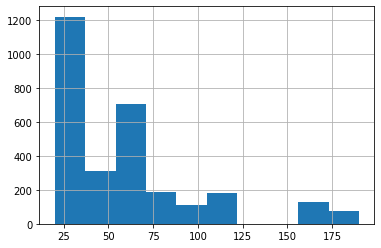

######################## LotFrontage #############################


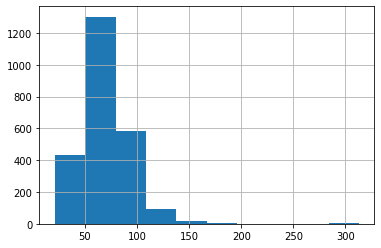

######################## LotArea #############################


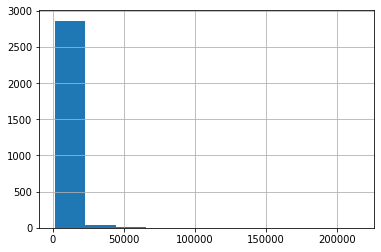

######################## OverallQual #############################


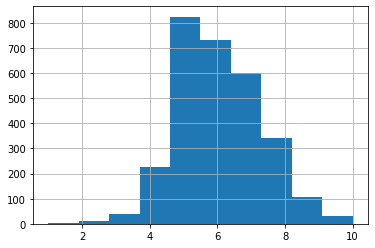

######################## OverallCond #############################


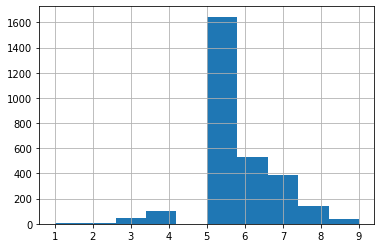

######################## YearBuilt #############################


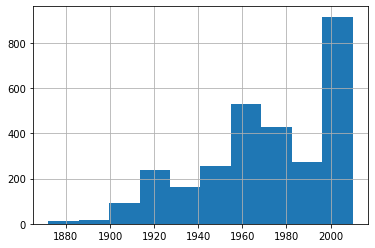

######################## YearRemodAdd #############################


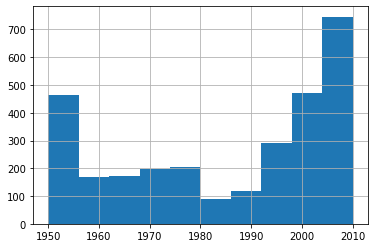

######################## MasVnrArea #############################


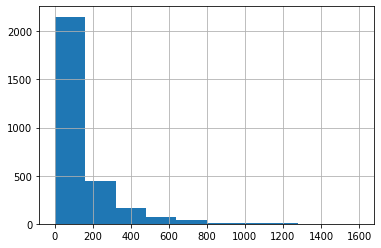

######################## BsmtFinSF1 #############################


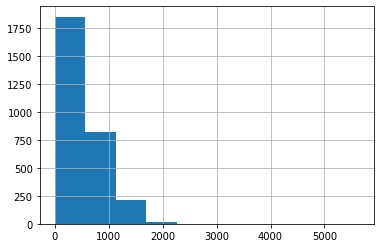

######################## BsmtFinSF2 #############################


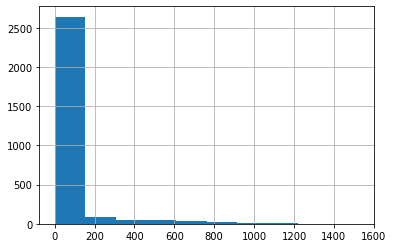

######################## BsmtUnfSF #############################


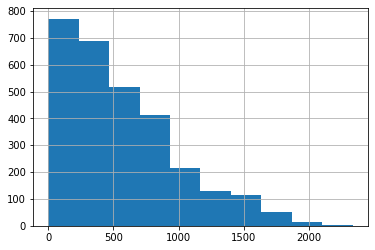

######################## TotalBsmtSF #############################


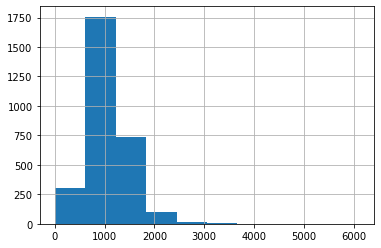

######################## 1stFlrSF #############################


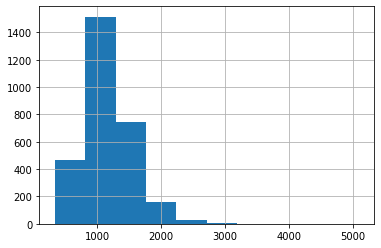

######################## 2ndFlrSF #############################


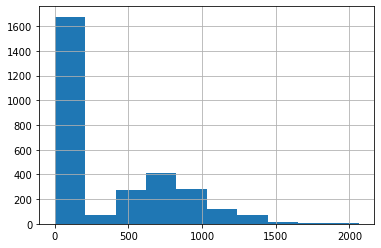

######################## LowQualFinSF #############################


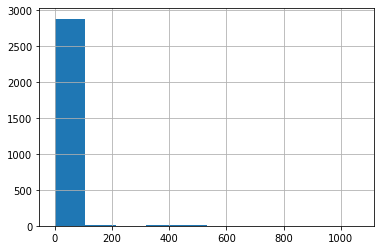

######################## GrLivArea #############################


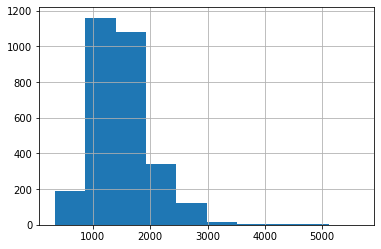

######################## BsmtFullBath #############################


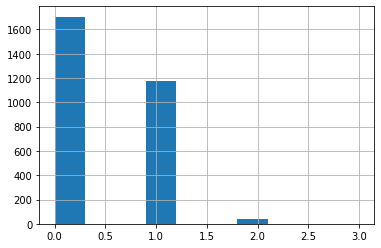

######################## BsmtHalfBath #############################


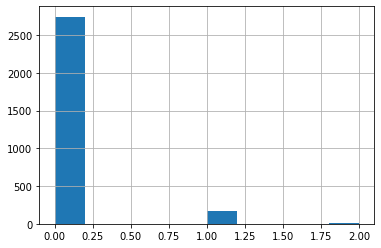

######################## FullBath #############################


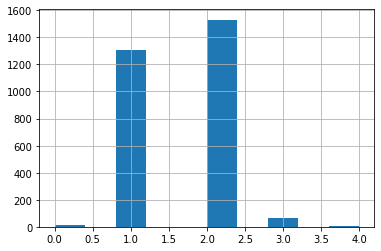

######################## HalfBath #############################


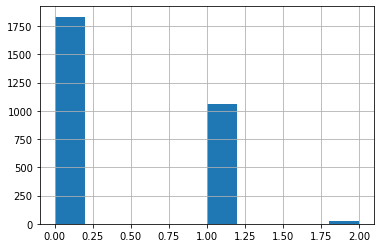

######################## BedroomAbvGr #############################


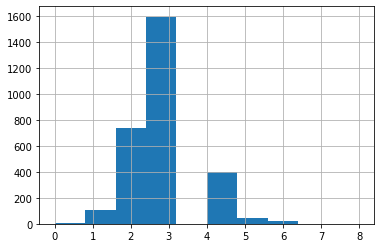

######################## KitchenAbvGr #############################


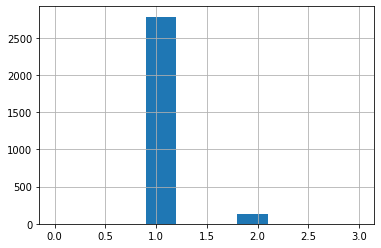

######################## TotRmsAbvGrd #############################


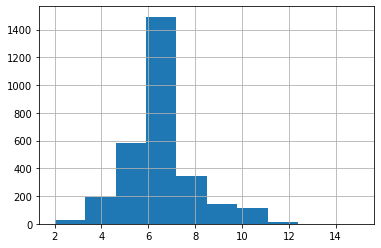

######################## Fireplaces #############################


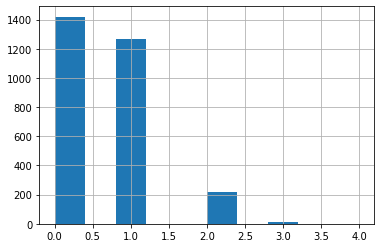

######################## GarageYrBlt #############################


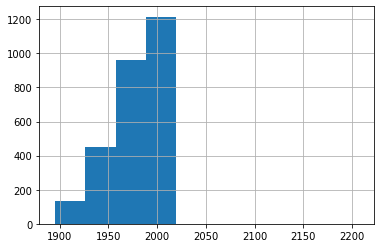

######################## GarageCars #############################


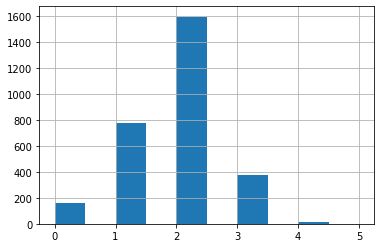

######################## GarageArea #############################


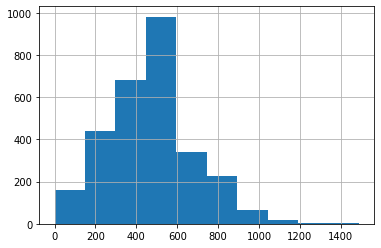

######################## WoodDeckSF #############################


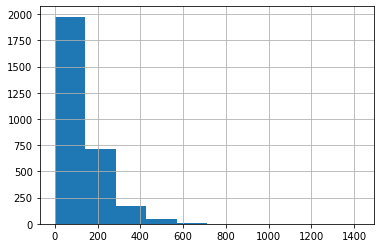

######################## OpenPorchSF #############################


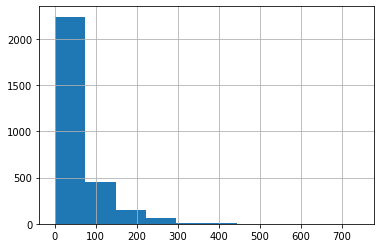

######################## EnclosedPorch #############################


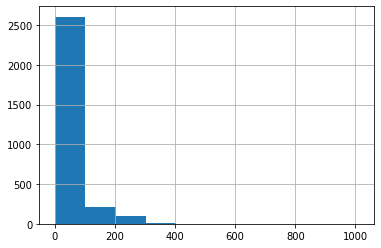

######################## 3SsnPorch #############################


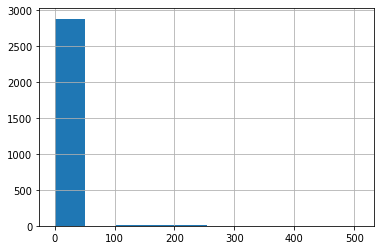

######################## ScreenPorch #############################


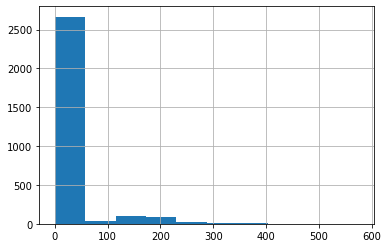

######################## PoolArea #############################


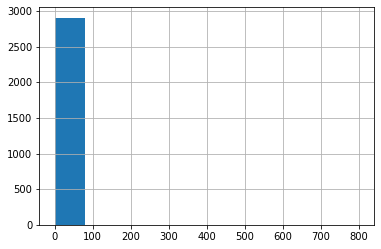

######################## MiscVal #############################


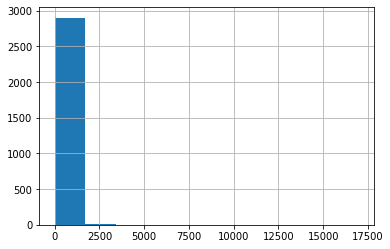

######################## MoSold #############################


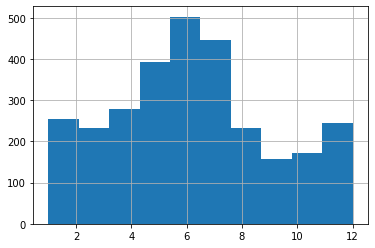

######################## YrSold #############################


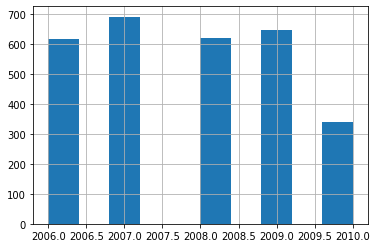

######################## SalePrice #############################


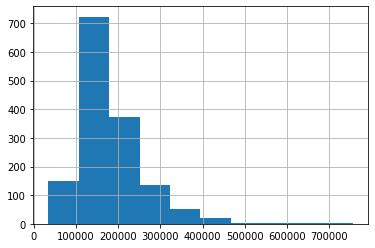

In [11]:
def Numeric(df, plot = False):
    
    num_cols = [cols for cols in data.columns if df[cols].dtypes != 'object'
               and cols not in 'Id']
    
    for cols in num_cols:
        
        if plot:
            
            print(f"######################## {cols} #############################")
            df[cols].hist()
            plt.show()

Numeric(data, plot=True)            

# Hedef Değişken Analizi 

- Bizim Hedef Değişkenimiz **SalePrice** değişkenidir.
- Hedef Değişkenimiz ile Benzersiz Veri sayısı 10'dan küçük olan değişkenlerimize göre gruplayıp,
  **ortalama** alıyoruz.

In [12]:
data.groupby("Street")['SalePrice'].mean()

Street
Grvl    130190.500000
Pave    181130.538514
Name: SalePrice, dtype: float64

In [13]:
data.groupby('Street').agg({'SalePrice':'mean'})

,SalePrice
Street,
Grvl,130190.500000
Pave,181130.538514


In [14]:
def Target(df, cat_number = 10, target = 'SalePrice'):
    
    cat_cols = [cols for cols in df.columns if df[cols].nunique() < int(cat_number)]
    
    for cols in cat_cols:

        data_new = pd.DataFrame({'Count':df[cols].value_counts(),
                                'Ratio':df[cols].value_counts() / len(df),
                                'Hedef Count':df.groupby(cols)[target].count(),
                                'Hedef Ortalama':df.groupby(cols)[target].mean(),
                                'Hedef Std':df.groupby(cols)[target].std()})
        
        print(f"###################### {df[cols].name} ########################",end = "\n\n")
        print(data_new, end = "\n\n")
        
Target(df = data, cat_number = 10, target = "SalePrice")

###################### MSZoning ########################

         Count     Ratio  Hedef Count  Hedef Ortalama     Hedef Std
C (all)     25  0.008565           10    74528.000000  33791.092031
FV         139  0.047619           65   214014.061538  52369.662067
RH          26  0.008907           16   131558.375000  35714.118435
RL        2265  0.775951         1151   191004.994787  80766.341319
RM         460  0.157588          218   126316.830275  48521.689833

###################### Street ########################

      Count     Ratio  Hedef Count  Hedef Ortalama     Hedef Std
Grvl     12  0.004111            6   130190.500000  65446.253991
Pave   2907  0.995889         1454   181130.538514  79446.597317

###################### Alley ########################

      Count     Ratio  Hedef Count  Hedef Ortalama     Hedef Std
Grvl    120  0.041110           50   122219.080000  34780.780734
Pave     78  0.026721           41   168000.585366  38370.375243

###################### LotShap

# Sayısal Değişken 

In [15]:
data.groupby('Street').agg({'PoolArea':'max','GarageArea':'mean','FullBath':'min'})

,PoolArea,GarageArea,FullBath
Street,,,
Grvl,0,461.500000,1
Pave,800,472.921542,0


- Sayısal Değişkenlerimizin, **Korelasyonuna** Bakalım

In [16]:
data.corr()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.008931,-0.027549,-0.040746,-0.029771,-0.002839,-0.016581,-0.050438,-0.025219,-0.016947,...,-0.007056,0.009960,0.021609,-0.046538,0.022208,0.014332,0.008244,0.006448,-0.256050,-0.021917
MSSubClass,0.008931,1.000000,-0.417359,-0.201730,0.033638,-0.065625,0.034409,0.043315,0.005433,-0.064311,...,-0.017654,-0.015923,-0.020867,-0.037529,-0.049181,-0.003080,-0.028867,-0.001231,-0.015028,-0.084284
LotFrontage,-0.027549,-0.417359,1.000000,0.489896,0.217645,-0.075508,0.122811,0.091557,0.221079,0.219408,...,0.122070,0.164896,0.011509,0.028289,0.075858,0.174119,0.044272,0.011254,-0.007917,0.351799
LotArea,-0.040746,-0.201730,0.489896,1.000000,0.100541,-0.035617,0.024128,0.021612,0.125596,0.194031,...,0.158045,0.104797,0.020974,0.015995,0.054375,0.093708,0.069029,0.004156,-0.024234,0.263843
OverallQual,-0.029771,0.033638,0.217645,0.100541,1.000000,-0.093847,0.597554,0.571532,0.432947,0.281810,...,0.255317,0.298084,-0.139256,0.018715,0.042910,0.030740,0.005562,0.030405,-0.019614,0.790982
OverallCond,-0.002839,-0.065625,-0.075508,-0.035617,-0.093847,1.000000,-0.368477,0.047654,-0.136007,-0.050418,...,0.020123,-0.068978,0.071044,0.043739,0.043713,-0.016876,0.033956,-0.006256,0.030102,-0.077856
YearBuilt,-0.016581,0.034409,0.122811,0.024128,0.597554,-0.368477,1.000000,0.612235,0.314051,0.279581,...,0.229426,0.198554,-0.374073,0.015958,-0.041046,0.002304,-0.010886,0.013938,-0.012344,0.522897
YearRemodAdd,-0.050438,0.043315,0.091557,0.021612,0.571532,0.047654,0.612235,1.000000,0.196875,0.152126,...,0.218513,0.242182,-0.220456,0.037433,-0.046878,-0.011407,-0.003124,0.017693,0.033203,0.507101
MasVnrArea,-0.025219,0.005433,0.221079,0.125596,0.432947,-0.136007,0.314051,0.196875,1.000000,0.303490,...,0.166200,0.144650,-0.111499,0.013612,0.065209,0.004512,0.044811,-0.000117,-0.018510,0.477493
BsmtFinSF1,-0.016947,-0.064311,0.219408,0.194031,0.281810,-0.050418,0.279581,0.152126,0.303490,1.000000,...,0.223492,0.124163,-0.099712,0.050908,0.096823,0.084462,0.093295,-0.000942,0.022556,0.386420


In [17]:
def correlation(df,num_cols, target='SalePrice',corr_limit=0.50):
    
    high = []
    
    low = []
    
    for cols in num_cols:
        
        if cols == 'SalePrice':
            pass
        else:
            
            corr = df[[cols,target]].corr().loc[cols, target]
            
            if abs(corr) > corr_limit: #abs() fonksiyonu mutlak değer alır.
                
                high.append(cols  + ":" + str(corr))
            else:
                low.append(cols + ":" + str(corr))
                
    cache = {'Low Correlations Features':low,'High Correlations Features':high}    
                      
    return cache

num_cols = [cols for cols in data.columns if data[cols].dtype != 'object']

correlation(data,num_cols,target='SalePrice',corr_limit=0.50)

{'Low Correlations Features': ['Id:-0.021916719443430967',
  'MSSubClass:-0.08428413512659509',
  'LotFrontage:0.35179909657067737',
  'LotArea:0.2638433538714051',
  'OverallCond:-0.07785589404867797',
  'MasVnrArea:0.47749304709571444',
  'BsmtFinSF1:0.3864198062421535',
  'BsmtFinSF2:-0.011378121450215146',
  'BsmtUnfSF:0.21447910554696928',
  '2ndFlrSF:0.31933380283206736',
  'LowQualFinSF:-0.02560613000067955',
  'BsmtFullBath:0.22712223313149427',
  'BsmtHalfBath:-0.01684415429735895',
  'HalfBath:0.28410767559478256',
  'BedroomAbvGr:0.16821315430073963',
  'KitchenAbvGr:-0.13590737084214105',
  'Fireplaces:0.46692883675152763',
  'GarageYrBlt:0.4863616774878596',
  'WoodDeckSF:0.32441344456812926',
  'OpenPorchSF:0.31585622711605504',
  'EnclosedPorch:-0.1285779579259566',
  '3SsnPorch:0.04458366533574838',
  'ScreenPorch:0.11144657114291112',
  'PoolArea:0.09240354949187318',
  'MiscVal:-0.021189579640303213',
  'MoSold:0.046432245223819446',
  'YrSold:-0.028922585168736813'],

# Missing Values

In [18]:
data.isnull().values.any()

True

In [19]:
data.isnull().sum().sum()

15424

In [20]:
data.columns[data.isnull().any()].tolist()

['MSZoning',
 'LotFrontage',
 'Alley',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Electrical',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SalePrice']

- **Eksik veriye sahip değişkenleri** verir

In [21]:
data[data.isnull().any(axis=1)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


- Tam olan gözlerm birimlerini verir.

In [22]:
data[data.notnull().all(axis=1)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [23]:
[cols for cols in data.columns if data[cols].isnull().any()]

['MSZoning',
 'LotFrontage',
 'Alley',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Electrical',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SalePrice']

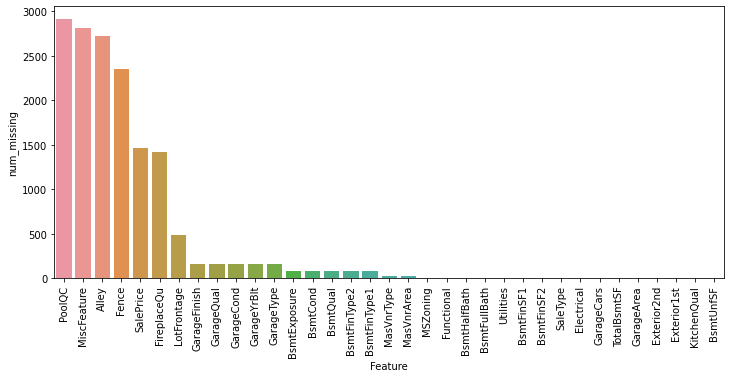

%90'ı Eksik Veri Olan Değişkenler : ['PoolQC', 'MiscFeature', 'Alley']


,Feature,num_missing,Ratio,Datatypes
0,PoolQC,2909,0.996574,object
1,MiscFeature,2814,0.964029,object
2,Alley,2721,0.932169,object
3,Fence,2348,0.804385,object
4,SalePrice,1459,0.499829,float64
5,FireplaceQu,1420,0.486468,object
6,LotFrontage,486,0.166495,float64
7,GarageFinish,159,0.054471,object
8,GarageQual,159,0.054471,object
9,GarageCond,159,0.054471,object


In [24]:
def miss_value(df, plot= False):
    
    miss_data = pd.DataFrame({'num_missing':df.isnull().sum(),
                            'Ratio':df.isnull().sum() / len(df)})
    
    miss_data['Datatypes'] = data[miss_data.index].dtypes.values
    
    miss_data = miss_data.sort_values('num_missing', ascending = False)
    
    miss_data = miss_data[miss_data['num_missing'] > 0].reset_index().rename({'index':'Feature'}, axis=1)    
          
    if plot:
        
        plt.figure(figsize=(12,5))
        p = sns.barplot(x = miss_data['Feature'], y = miss_data['num_missing']);   
    
        for rotate in p.get_xticklabels(): #x ekseninde ki her değişken ismini 90 olarak ayarladık. yatay şekilde.
            
            rotate.set_rotation(90)
        plt.show()
        
        miss_90 = miss_data[miss_data['Ratio'] > 0.90]['Feature'].tolist() 
        
        print(f"%90'ı Eksik Veri Olan Değişkenler : {miss_90}")
        
    return miss_data
        
miss_data = miss_value(data, plot=True)

miss_data

In [25]:
miss_data[miss_data['Ratio'] > 0.80].Feature.tolist(), data.shape

(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], (2919, 81))

- Değerlerinin %90'ı eksik veri olan değişkenleri datamızdan siliyoruz

In [26]:
data = data.drop(miss_data[miss_data['Ratio'] > 0.80]['Feature'].tolist(), axis=1)

data.shape

(2919, 77)

- Bu **Object data tipine sahip** olan eksik değerleri olan değişkenler arasından;
   
   - Eksik Değer toplamı 100'den fazla olanı ve az olanı bıze veren fonksiyon yazalım.

In [27]:
def miss_count(df):
    
    up_count = []
    
    low_count = []
    
    data_x = [cols for cols in df.columns if df[cols].isnull().any()
             and df[cols].dtypes == 'object']
    
    for cols in data_x:
        
        count = df[cols].isnull().sum()
        
        if count > 100:
            
            up_count.append((cols,count))
        else:
            low_count.append((cols,count))
    
    print("100'den az eksik değeri olan değişkenler", end = "\n\n")
    
    for i,j in low_count:
        
        print(f"{i} == {j}", end = "\n")
    
    print("100'den fazla eksik değeri olan değişkenler", end = "\n\n")
    
    for i,j in up_count:
        
        print(f"{i} == {j}")
    
    
miss_count(data)       

100'den az eksik değeri olan değişkenler

MSZoning == 4
Utilities == 2
Exterior1st == 1
Exterior2nd == 1
MasVnrType == 24
BsmtQual == 81
BsmtCond == 82
BsmtExposure == 82
BsmtFinType1 == 79
BsmtFinType2 == 80
Electrical == 1
KitchenQual == 1
Functional == 2
SaleType == 1
100'den fazla eksik değeri olan değişkenler

FireplaceQu == 1420
GarageType == 157
GarageFinish == 159
GarageQual == 159
GarageCond == 159


- **Object** değişkene sahip olmayan **Eksik Değere** sahip değişkenlerimizi alalım

In [28]:
[cols for cols in data.columns if data[cols].isnull().any()
and data[cols].dtypes != 'object']

['LotFrontage',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'SalePrice']

- **Object** data tipine sahip olmayan **Eksik Değere** Sahip değişkenlerimizin, *Eksik Değerlerini* **Mode**'u ile dolduracağız 

In [29]:
def miss_flo(df):
    
    miss_cols = [cols for cols in df.columns if df[cols].isnull().any()
                and df[cols].dtypes != 'object']
    
    for cols in miss_cols:
        
        df[cols] = df[cols].fillna(df[cols].mode()[0])
        
        print(f"{df[cols].name} = {df[cols].isnull().any()}")
        
miss_flo(data)

LotFrontage = False
MasVnrArea = False
BsmtFinSF1 = False
BsmtFinSF2 = False
BsmtUnfSF = False
TotalBsmtSF = False
BsmtFullBath = False
BsmtHalfBath = False
GarageYrBlt = False
GarageCars = False
GarageArea = False
SalePrice = False


In [30]:
miss_cols = [cols for cols in data.columns if data[cols].isnull().any()
and data[cols].dtypes == 'object']

for cols in miss_cols:
    
    print(f"{cols} ===== {data[cols].isnull().sum()}")

MSZoning ===== 4
Utilities ===== 2
Exterior1st ===== 1
Exterior2nd ===== 1
MasVnrType ===== 24
BsmtQual ===== 81
BsmtCond ===== 82
BsmtExposure ===== 82
BsmtFinType1 ===== 79
BsmtFinType2 ===== 80
Electrical ===== 1
KitchenQual ===== 1
Functional ===== 2
FireplaceQu ===== 1420
GarageType ===== 157
GarageFinish ===== 159
GarageQual ===== 159
GarageCond ===== 159
SaleType ===== 1


In [31]:
def fill_cat(df):
    
    miss_cat = [cols for cols in df.columns if df[cols].isnull().any()
               and df[cols].dtypes == 'object']
    
    for cols in miss_cat:
        
        df[cols] = df[cols].fillna(df[cols].mode()[0])
        
        print(f"{cols} == {df[cols].isnull().sum()}")

fill_cat(data)

MSZoning == 0
Utilities == 0
Exterior1st == 0
Exterior2nd == 0
MasVnrType == 0
BsmtQual == 0
BsmtCond == 0
BsmtExposure == 0
BsmtFinType1 == 0
BsmtFinType2 == 0
Electrical == 0
KitchenQual == 0
Functional == 0
FireplaceQu == 0
GarageType == 0
GarageFinish == 0
GarageQual == 0
GarageCond == 0
SaleType == 0


# Outliers

In [32]:
num_cols = [cols for cols in data.columns if data[cols].dtypes != 'object'
           and cols not in 'Id' and cols not in 'SalePrice']
num_cols, len(num_cols)

(['MSSubClass',
  'LotFrontage',
  'LotArea',
  'OverallQual',
  'OverallCond',
  'YearBuilt',
  'YearRemodAdd',
  'MasVnrArea',
  'BsmtFinSF1',
  'BsmtFinSF2',
  'BsmtUnfSF',
  'TotalBsmtSF',
  '1stFlrSF',
  '2ndFlrSF',
  'LowQualFinSF',
  'GrLivArea',
  'BsmtFullBath',
  'BsmtHalfBath',
  'FullBath',
  'HalfBath',
  'BedroomAbvGr',
  'KitchenAbvGr',
  'TotRmsAbvGrd',
  'Fireplaces',
  'GarageYrBlt',
  'GarageCars',
  'GarageArea',
  'WoodDeckSF',
  'OpenPorchSF',
  'EnclosedPorch',
  '3SsnPorch',
  'ScreenPorch',
  'PoolArea',
  'MiscVal',
  'MoSold',
  'YrSold'],
 36)

- Değişkenlerimizin, **Alt Eşik** ve **Üst Eşik** Değerlerinin bize veren fonksiyon yazalım


In [33]:
def alt_üst_eşik(df,feature):
    
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = np.multiply(1.5, np.subtract(Q3,Q1))
        
    alt_eşik = IQR - Q1
    üst_eşik = IQR + Q3
        
    return alt_eşik, üst_eşik
        
        
alt,üst = alt_üst_eşik(data,feature = "MSSubClass")

alt, üst

(55.0, 145.0)

- Bir Değişkende **Aykırı Değer Olup Olmadığını** kontrol eden fonksiyon yazalım

In [34]:
def variable_Out(df,feature):
    
    result = []
    
    alt, üst = alt_üst_eşik(df, feature) # alt, üst eşik değerlerinin veren fonksiyonu kullandık
    
    #out_num = df[feature][(df[feature] < alt) | (df[feature] > üst)].count()
    
    if df[feature][(df[feature] <alt) | (df[feature] > üst)].any(axis=None): 
    
    #if out_num > 0:    
        
        result.append("Yes")
    else:
        result.append("No")
        
    return result
        
    
variable_Out(data,feature = 'LotFrontage')  

['Yes']

In [35]:
variable_Out(data, feature = 'SalePrice')

['Yes']

In [36]:
data['MSSubClass'][(data['MSSubClass'] < alt) | (data['MSSubClass'] > üst)].count()

1736

In [37]:
data['MSSubClass'][(data['MSSubClass'] < alt)].count()

1529

In [38]:
 data['MSSubClass'][(data['MSSubClass'] > üst)].count()

207

- **Aykırı Değeri olan** değişkenleri bize veren, **alt ve üst eşik değerlerini** bize veren fonksiyon yazalım.

In [39]:
def Outliers(df):
    
    aykırı = []
    
    aykırı_yok = []
    
    num_cols = [cols for cols in df.columns if df[cols].dtypes != 'object'
               and cols not in 'SalePrice'
               and cols not in 'Id']
    
    for cols in num_cols:
        
        Q1 = df[cols].quantile(0.25)
        Q3 = df[cols].quantile(0.75)
        
        IQR = np.multiply(1.5 , np.subtract(Q3, Q1))
        
        alt_sınır = IQR - Q1
        üst_sınır = IQR + Q3
        
        
        number = df[cols][(df[cols] < alt_sınır) | (df[cols] > üst_sınır)].count()
        
        if number > 0:
            
            aykırı.append(cols)
            
            cache = {'Alt_Sınır':alt_sınır,
                     'Üst Sınır':üst_sınır,
                    'Toplam Aykırı Değer':number}
                
            print(f"############# {df[cols].name} ###############",end = "\n\n")
        
            print(cache, end = "\n\n")
        
        else:
            
            aykırı_yok.append(cols)
            
    print(f"Aykırı Değer Olan Değişken Sayısı = {len(aykırı)}\nAykırı Değer Olmayan Değişkenler = {aykırı_yok}")
    
    return 
    
Outliers(data)

############# MSSubClass ###############

{'Alt_Sınır': 55.0, 'Üst Sınır': 145.0, 'Toplam Aykırı Değer': 1736}

############# LotFrontage ###############

{'Alt_Sınır': -33.0, 'Üst Sınır': 105.0, 'Toplam Aykırı Değer': 135}

############# LotArea ###############

{'Alt_Sınır': -1340.0, 'Üst Sınır': 17708.0, 'Toplam Aykırı Değer': 127}

############# OverallCond ###############

{'Alt_Sınır': -3.5, 'Üst Sınır': 7.5, 'Toplam Aykırı Değer': 185}

############# MasVnrArea ###############

{'Alt_Sınır': 245.25, 'Üst Sınır': 408.75, 'Toplam Aykırı Değer': 2655}

############# BsmtFinSF1 ###############

{'Alt_Sınır': 1099.5, 'Üst Sınır': 1832.5, 'Toplam Aykırı Değer': 2675}

############# BsmtFinSF2 ###############

{'Alt_Sınır': 0.0, 'Üst Sınır': 0.0, 'Toplam Aykırı Değer': 347}

############# BsmtUnfSF ###############

{'Alt_Sınır': 657.5, 'Üst Sınır': 1682.5, 'Toplam Aykırı Değer': 1937}

############# TotalBsmtSF ###############

{'Alt_Sınır': -29.5, 'Üst Sınır': 2065.5, 'Toplam Aykırı D

- Aykırı Değer Olan Değişkenlerin **100 'den fazla Aykırı Değeri olan** değişkenleri alalım.
- Aynı zamanda bu değişkenlerin Boxplot'unu çizdirelim

-----MSSubClass-----
Toplam Aykırı Değer Sayısı :207


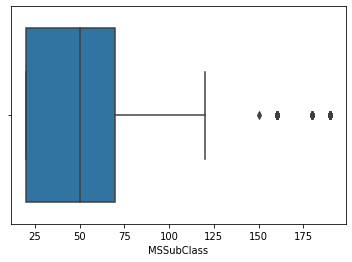

-----LotFrontage-----
Toplam Aykırı Değer Sayısı :260


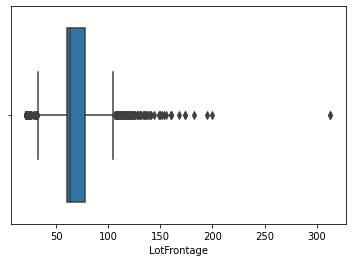

-----LotArea-----
Toplam Aykırı Değer Sayısı :128


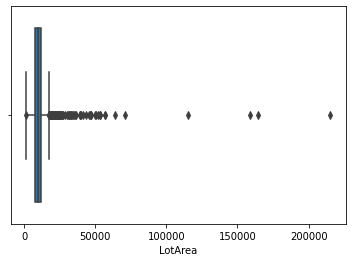

-----OverallCond-----
Toplam Aykırı Değer Sayısı :252


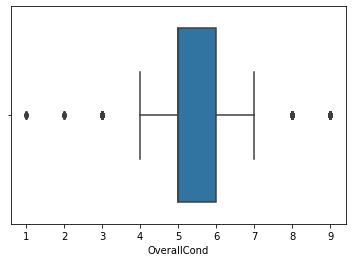

-----MasVnrArea-----
Toplam Aykırı Değer Sayısı :202


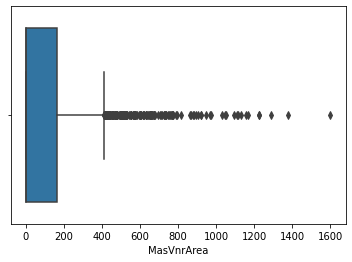

-----BsmtFinSF2-----
Toplam Aykırı Değer Sayısı :347


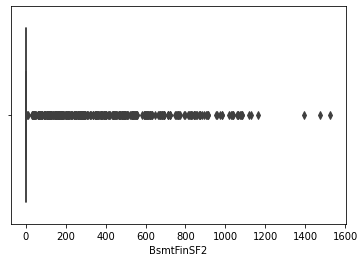

-----TotalBsmtSF-----
Toplam Aykırı Değer Sayısı :123


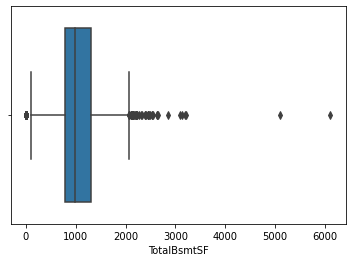

-----BsmtHalfBath-----
Toplam Aykırı Değer Sayısı :175


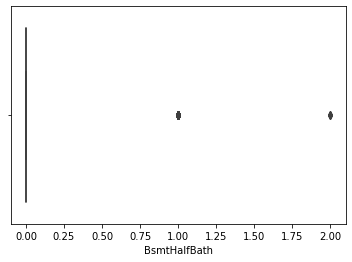

-----KitchenAbvGr-----
Toplam Aykırı Değer Sayısı :134


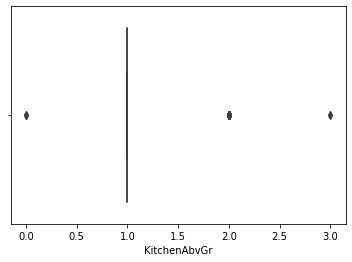

-----OpenPorchSF-----
Toplam Aykırı Değer Sayısı :159


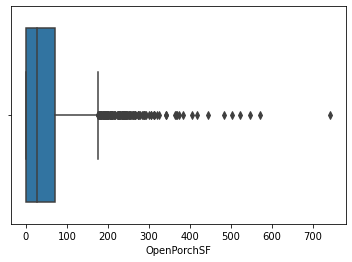

-----EnclosedPorch-----
Toplam Aykırı Değer Sayısı :459


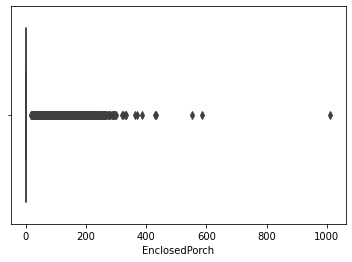

-----ScreenPorch-----
Toplam Aykırı Değer Sayısı :256


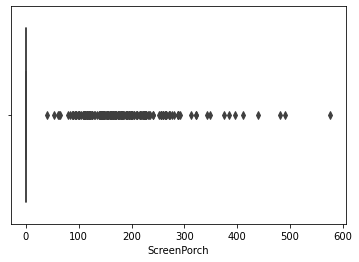

-----MiscVal-----
Toplam Aykırı Değer Sayısı :103


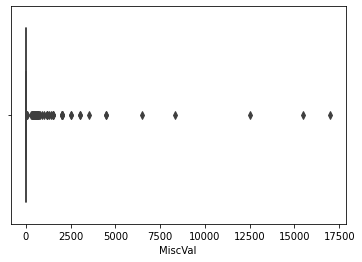

Toplam Değişken Sayısı : 13


In [40]:
def up_number_outliers(df, number,plot = False):
    
    out_features = []
    
    num_cols = [cols for cols in df.columns if df[cols].dtypes != 'object'
               and cols not in 'SalePrice'
               and cols not in 'Id']
    
    for cols in num_cols:
        
        Q1 = df[cols].quantile(0.25)
        Q3 = df[cols].quantile(0.75)
        IQR = np.multiply(1.5, np.subtract(Q3,Q1))
        
        alt_eşik = Q1 - IQR
        üst_eşik = IQR + Q3
        
        out_cols = df[cols][(df[cols] < alt_eşik) | (df[cols] > üst_eşik)].count()
        
        if out_cols > int(number):
            
            out_features.append(cols)
            
            print(f"-----{cols}-----\nToplam Aykırı Değer Sayısı :{out_cols}")
            
            if plot:
                
                sns.boxplot(df[cols]);
                plt.show()
                
    print(f"Toplam Değişken Sayısı : {len(out_features)}")
         
            
up_number_outliers(data, number=100, plot=True)

- Aykırı Değeri olan Değişkenlerimizin , **alt_eşik** ve **üst_eşik** değerleri,**0 olmayan** değişkenleri bize veren fonskiyon yazalım
- Aynı Zaman da **Alt Aykırı Değerlerin ve Üst Aykırı Değerlerin Toplam Sayısını** yazdıralım.

In [41]:
def analiz_eşik(df):
    
    out_value = []
    zero_alt_üst = []
    
    num_cols = [cols for cols in df.columns if df[cols].dtypes != 'object'
               and cols not in 'SalePrice'
               and cols not in  'Id']
    
    for cols in num_cols:
        
        alt,üst = alt_üst_eşik(df,feature = cols)
        
        if alt !=0 and üst!=0:
            
            alt_değer = df[cols][df[cols] < alt].count()
            üst_değer = df[cols][df[cols] > üst].count()
            out_value.append((cols,alt,üst,alt_değer,üst_değer))
            
            if alt_değer == 0 and üst_değer == 0:
                
                zero_alt_üst.append(cols)
            
            
    for i,j,k,f,y in out_value:
        
        print(f"Değişken : {i}\nAlt Eşik : {j}\nÜst Eşik :{k}\n"
              f"Toplam Alt Aykırı Değer : {f}\nToplam Üst Aykırı Değer :{y}",end = "\n\n\n")
        #print(i,j,k) #Bu şekilde de yazabiliriz.
        
    print(f"Alt Ve Üst Aykırı Değerleri Olmayan Değişkenler : {zero_alt_üst}")
                
analiz_eşik(data)

Değişken : MSSubClass
Alt Eşik : 55.0
Üst Eşik :145.0
Toplam Alt Aykırı Değer : 1529
Toplam Üst Aykırı Değer :207


Değişken : LotFrontage
Alt Eşik : -33.0
Üst Eşik :105.0
Toplam Alt Aykırı Değer : 0
Toplam Üst Aykırı Değer :135


Değişken : LotArea
Alt Eşik : -1340.0
Üst Eşik :17708.0
Toplam Alt Aykırı Değer : 0
Toplam Üst Aykırı Değer :127


Değişken : OverallQual
Alt Eşik : -2.0
Üst Eşik :10.0
Toplam Alt Aykırı Değer : 0
Toplam Üst Aykırı Değer :0


Değişken : OverallCond
Alt Eşik : -3.5
Üst Eşik :7.5
Toplam Alt Aykırı Değer : 0
Toplam Üst Aykırı Değer :185


Değişken : YearBuilt
Alt Eşik : -1882.25
Üst Eşik :2072.25
Toplam Alt Aykırı Değer : 0
Toplam Üst Aykırı Değer :0


Değişken : YearRemodAdd
Alt Eşik : -1906.5
Üst Eşik :2062.5
Toplam Alt Aykırı Değer : 0
Toplam Üst Aykırı Değer :0


Değişken : MasVnrArea
Alt Eşik : 245.25
Üst Eşik :408.75
Toplam Alt Aykırı Değer : 2453
Toplam Üst Aykırı Değer :202


Değişken : BsmtFinSF1
Alt Eşik : 1099.5
Üst Eşik :1832.5
Toplam Alt Aykırı Değe

- **Aykırı Değere sahip** değişkenlerimizin Aykırı Değerlerini, **alt_eşik** ve **üst_eşik** değerlerine baskılayacağız.

- Baskılama İşlemi Yaparken, **Toplam Alt ve Üst Değerlerin Sayısı 0 olan Değişkenleri** **almayacağız**.

- Bu Değişkenleri bize veren fonskiyon yazalım

In [42]:
def Zero_features(df):
    
    zero= []
    
    num_cols = [cols for cols in df.columns if df[cols].dtypes != 'object'
               and cols not in 'SalePrice'
               and cols not in 'Id']
    
    for cols in num_cols:
        
        alt,üst = alt_üst_eşik(df,feature=cols)
        
        if alt != 0 and üst != 0:
            
            alt_değer = df[cols][df[cols] < alt].count()
            üst_değer = df[cols][df[cols] > üst].count()
            
            if alt_değer == 0 and üst_değer == 0:
                
                zero.append(cols)
                
    return zero

değişkenler = Zero_features(data)

değişkenler

['OverallQual', 'YearBuilt', 'YearRemodAdd', 'YrSold']

- Aykırı Değere Sahip Değişkenlerimizi Alt ve Üst Eşik Değerlerine baskılayacağız.

In [43]:
def press_outliers(df):
    
    features = Zero_features(df) #Toplam alt ve üst aykırı değerleri 0 olan değişkenler
    
    num_cols = [cols for cols in df.columns if df[cols].dtypes != 'object'
               and cols not in 'SalePrice'
               and cols not in 'Id'
               and cols not in features]
    
    for cols in num_cols:
        
        alt_eşik, üst_eşik = alt_üst_eşik(df, feature = cols)
        
        if alt_eşik != 0 and üst_eşik !=0:
            
            alt = df[cols][df[cols] < alt_eşik].count()
            üst = df[cols][df[cols] > üst_eşik].count()
            
            if alt == 0 :  #alt aykırı değeri olmayanların üst aykırı değerleri vardı.Onları üst eşik değere baskıladık
                
                df[cols][(df[cols] > üst_eşik)] = üst_eşik
                
            elif üst == 0: #üst aykırı değeri olmayanların alt aykırı değerleri vardı.Onları alt eşik değere baskıladık
                
                df[cols][(df[cols] < alt_eşik)] = alt_eşik
                
            elif alt != 0 and üst != 0:
                
                df[cols][(df[cols] < alt_eşik)] = alt_eşik
                df[cols][(df[cols] > üst_eşik)] = üst_eşik 
            
            print(f"{cols} = {df[cols][(df[cols] < alt_eşik) | (df[cols] > üst_eşik)].count()}") #Değişkenlerimiz için Aykırı Değer kontrolü yapacak
    
    
press_outliers(data)    

MSSubClass = 0
LotFrontage = 0
LotArea = 0
OverallCond = 0
MasVnrArea = 0
BsmtFinSF1 = 0
BsmtUnfSF = 0
TotalBsmtSF = 0
1stFlrSF = 0
2ndFlrSF = 0
GrLivArea = 0
BsmtFullBath = 0
FullBath = 0
HalfBath = 0
BedroomAbvGr = 0
KitchenAbvGr = 0
TotRmsAbvGrd = 0
Fireplaces = 0
GarageYrBlt = 0
GarageCars = 0
GarageArea = 0
WoodDeckSF = 0
OpenPorchSF = 0
MoSold = 0


- Hedef Değişkenimizin **alt eşik ve üst eşik** değerlerine bakalım

In [44]:
alt_üst_eşik(data, feature='SalePrice')

(-105500.0, 197500.0)

- Hedef Değişkenimizin **Toplam Aykırı Değerlerini** bize veren fonksiyon yazalım.

In [45]:
def Target_Out(df,feature = 'SalePrice'):
    
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    
    IQR = np.multiply(1.5, np.subtract(Q3, Q1))
    
    alt_eşik = IQR - Q1
    üst_eşik = IQR + Q3
    
    alt = df[feature][df[feature] < alt_eşik].count()
    üst = df[feature][df[feature] > üst_eşik].count()
    
    return alt, üst
    
Target_Out(data,'SalePrice')

(0, 442)

- Hedef Değişkenimizin  **Alt Aykırı Değeri** yoktur.
- 61 tane **Üst Aykırı Değeri** vardır.
- Biz bu değerleri **Üst Eşik değerine baskılayacağız**

In [46]:
def Target_Press(df, target = 'SalePrice'):
    
    alt_eşik, üst_eşik = alt_üst_eşik(df, feature = target)
    
    df[target][df[target] > üst_eşik] = üst_eşik
    
    print(f"Aykırı Değer Sayısı : {df[target][df[target] > üst_eşik].count()}")

Target_Press(data, target='SalePrice')

Aykırı Değer Sayısı : 0


# Feature Engineering

- İlk olarak **agg** fonksiyonumuzu kullanarak,**Kategorik Değişkenlerimizin**,**Hedef Değişkenimize** etkisine bakacağız 

- İlk Olarak **Neighborhood** değişkenimiz ile başlayacağız

In [47]:
data.groupby('Neighborhood').agg({'SalePrice':'mean'}).sort_values('SalePrice',ascending = False)

,SalePrice
Neighborhood,
NoRidge,173098.591549
ClearCr,168498.454545
StoneBr,166941.176471
Blmngtn,166667.000000
Timber,166412.500000
NridgHt,165878.313253
Somerst,162465.576923
Veenker,162291.666667
CollgCr,161545.041199


- **Mahallelerin fiyata olan etkisini** görmüş olduk. 
- Şimdi ise bu **Mahalleleri SalePrice değişkenine etkisine göre numaralandıracağız.**. Şu şekide;

   - **MeadowW**  --> **1**
   - **NoRidge**  --> **10** şeklinde dönüştüreceğiz.

In [48]:
neih = {'MeadowV': 1, 'IDOTRR': 1, 'BrDale': 1,
                 'BrkSide': 2, 'Edwards': 2, 'OldTown': 2,
                 'Sawyer': 3, 'Blueste': 3,
                 'SWISU': 4, 'NPkVill': 4, 'NAmes': 4, 'Mitchel': 4,
                 'SawyerW': 5, 'NWAmes': 5,
                 'Gilbert': 6, 'Blmngtn': 6, 'CollgCr': 6,
                 'Crawfor': 7, 'ClearCr': 7,
                 'Somerst': 8, 'Veenker': 8, 'Timber': 8,
                 'StoneBr': 9, 'NridgHt': 9,
                 'NoRidge': 10}

data['Neighborhood'] = data['Neighborhood'].map(neih).astype('int')    

In [49]:
data['Neighborhood'].head()

0     6
1     8
2     6
3     7
4    10
Name: Neighborhood, dtype: int64

- **MoSold** değişkeninde aylara göre satış değerleri vardır.Bunları da Ay isimleri ile değiştireceğiz.

- Şu şekilde;

   - **1** --> **January**
   - **6** --> **June**


In [50]:
data['MoSold'].value_counts()

6     503
7     446
5     394
4     279
2     255
8     233
3     232
10    173
9     158
11    142
12    104
Name: MoSold, dtype: int64

In [51]:
data.groupby('MoSold').agg({'SalePrice':'mean'}).sort_values('SalePrice',ascending = False)

,SalePrice
MoSold,
12,152376.182692
11,151835.563380
8,150402.012876
7,150072.500000
9,149672.879747
6,149656.844930
10,149174.306358
3,148356.767241
5,147440.926396


In [52]:
data = data.replace({"MoSold": {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
                                7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}})

data['MoSold'].value_counts()

Jun    503
Jul    446
May    394
Apr    279
Feb    255
Aug    233
Mar    232
Oct    173
Sep    158
Nov    142
Dec    104
Name: MoSold, dtype: int64

- **Functional** değişkeni ; **Evin işlevsellik derecesinin** olduğu değişkendir.
- Bu değişkenin, **Hedef Değişken** üzerinde ki etkisine bakalım.

In [53]:
data.groupby('Functional').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending=False)

,SalePrice
Functional,
Typ,149633.933799
Maj1,142942.105263
Min1,141799.230769
Min2,140358.314286
Mod,139440.000000
Sev,134500.000000
Maj2,109888.888889


In [54]:
data['Functional'].value_counts()

Typ     2719
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64

- Evin işlevsellik değerlerinden SalePrice değişkenimize etkisi en çoktan en aza yukarıda gördüğümüz gibidir.
- Biz bu değerleri **Yüksekten Düşüğe** doğru numaralandıracağız.Şu Şekilde;

   - En Yüksek Değer -> **6** 'dan başlayarak **En Düşük** dereceye sahip sınıfa kadar numaralandıracağız.
   

In [55]:
func = {'Typ':6, 'Mod':5, 'Maj1':4, 'Min1':3,'Min2':2 ,'Sev':1 ,'Maj2':0}

data['Functional'] = data['Functional'].map(func).astype('int')

data['Functional'].value_counts()

6    2719
2      70
3      65
5      35
4      19
0       9
1       2
Name: Functional, dtype: int64

- Bazı kategorik değişkenlerimizin değerleri kendi aralarında belli bir derecelendirme halindedir.
- Bizde bunları ifade ettiği dereceye göre **Ordinal** hale getireceğiz.

- **MSZoning** Değişkeni, Genel **İmar Sınıflandırılması** olan değerlerden oluşur.


In [56]:
data['MSZoning'].value_counts()

RL         2269
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

- **MSZoning** değişkeninde ki değerlerin, **Hedef Değişkeni** miz üzerinde ki etkisine bakalım.

In [57]:
data.groupby('MSZoning').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
MSZoning,
FV,161091.618705
RL,152293.855884
RH,134709.000000
RM,131427.804348
C (all),113811.200000


In [58]:
data = data.replace({'MSZoning': {'FV':4, 'RL':3, 'RH':2, 'RM':1, 'C (all)':0}})

data['MSZoning'].value_counts()

3    2269
1     460
4     139
2      26
0      25
Name: MSZoning, dtype: int64

- **LotShape** Değişkeni, Mülkün Genel şeklini ifade eden değerleri bize verir.

- **LotShape** Değişkeninde ki değerlerin, **Hedef Değişkenimiz** üzerindeki etkisine bakalım

In [59]:
data.groupby('LotShape').agg({'SalePrice':'mean'}).sort_values('SalePrice',ascending=False)

,SalePrice
LotShape,
IR2,163714.921053
IR3,162321.250000
IR1,156144.115702
Reg,144466.928456


In [60]:
data = data.replace({'LotShape': {'IR2':4, 'IR3':3, 'IR1':2, 'Reg':1}})

data['LotShape'].value_counts()

1    1859
2     968
4      76
3      16
Name: LotShape, dtype: int64

- **LandContour** Değişkeni, Mülkün Düzlüğünü ifade eden sınıfları içerir.

- Bu Sınıfların, **Hedef Değişken** üzerinde ki etkilerine bakalım.

In [61]:
data.groupby('LandContour').agg({'SalePrice':'mean'}).sort_values('SalePrice',ascending = False)

,SalePrice
LandContour,
Low,155503.333333
HLS,154183.133333
Lvl,148975.882914
Bnk,139350.914530


In [62]:
data['LandContour'].value_counts()

Lvl    2622
HLS     120
Bnk     117
Low      60
Name: LandContour, dtype: int64

In [63]:
data = data.replace({'LandContour':{'HLS':4, 'Low':3, 'Lvl':2, 'Bnk':1}})

data['LandContour'].value_counts()

2    2622
4     120
1     117
3      60
Name: LandContour, dtype: int64

- **LotConfig** Değişkeni, Arazi Yapılandırmasını ifade eden sınıfları içerir.

- Bu sınıların, **Hedef Değişken** üzerinde ki etkilerine bakalım

In [64]:
data.groupby('LotConfig').agg({'SalePrice':'mean'}).sort_values('SalePrice',ascending = False)

,SalePrice
LotConfig,
CulDSac,160671.022727
FR2,152088.235294
FR3,150492.857143
Corner,149240.636008
Inside,147762.087670


- Yuakrıda gördüğümüz gibi **Hedef Değişken** üzerinde ki etkileri birbirlerine çok yakın değerler olduğu için **Ordinal** değer yaparken sadece 2 sınıf haline getireceğiz.
- 17... olanlar --> **1**
- 21 ve 20 olanlar --> **2** yapacağız.

In [65]:
data['LotConfig'].value_counts()

Inside     2133
Corner      511
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64

In [66]:
data = data.replace({'LotConfig':{'Inside':1, 'FR2':1, 'Corner':1, 'FR3':2,'CulDSac':2}})

data['LotConfig'].value_counts()

1    2729
2     190
Name: LotConfig, dtype: int64

- **Condition1** Değişkeni, AnaYola ve demiryoluna Yakınlığı ifade eden sınıfları barındırır.
- Bu sınıfların, **Hedef Değişken** üzerinde ki etkilerine bakalım

In [67]:
data.groupby('Condition1').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
Condition1,
PosA,160750.000000
PosN,160525.641026
RRNe,156916.666667
RRNn,154500.000000
RRAn,153494.100000
Norm,149830.428913
Feedr,139895.036585
RRAe,139371.428571
Artery,132602.173913


- **Hedef Değişken** etkileri, birbirine yakın olan sınıfları **Aynı Ordinal** değer yapacağız

In [68]:
data['Condition1'].value_counts()

Norm      2511
Feedr      164
Artery      92
RRAn        50
PosN        39
RRAe        28
PosA        20
RRNn         9
RRNe         6
Name: Condition1, dtype: int64

In [69]:
data = data.replace({'Condition1':{'Artery':1,'RRAe':1,'Feedr':2,'Norm':3,'RRAn':4,'RRNe':5,
                                  'RRNn':6,'PosN':6,'PosA':7}})

data['Condition1'].value_counts()

3    2511
2     164
1     120
4      50
6      48
7      20
5       6
Name: Condition1, dtype: int64

- **BldgType** Değişkeni, Konut Tipini ifade eden sınıflardan oluşur.
- Bu sınıfların, Hedef Değişken üzerinde ki etkilerine bakalım.

In [70]:
data.groupby('BldgType').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
BldgType,
TwnhsE,152361.744493
1Fam,150002.018969
Twnhs,137601.041667
Duplex,136815.009174
2fmCon,133668.548387


In [71]:
data['BldgType'].value_counts()

1Fam      2425
TwnhsE     227
Duplex     109
Twnhs       96
2fmCon      62
Name: BldgType, dtype: int64

- Hedef Değişken etkileri, birbirine yakın olan sınıfları Aynı değer yapacağız

In [72]:
data = data.replace({'BldgType': {'2fmCon':1,'Duplex':2,'Twnhs':2,'TwnhsE':3,'1Fam':3}})

data['BldgType'].value_counts()

3    2652
2     205
1      62
Name: BldgType, dtype: int64

- **RoofStyle** Değişkeni, Çatı Stilini ifade eden sınıfların bulunduğu değişkendir.
- Bu sınıfların, Hedef Değişken üzerinde ki etkilerine bakalım.

In [73]:
data.groupby('RoofStyle').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
RoofStyle,
Shed,161500.000000
Flat,158925.000000
Mansard,155545.454545
Hip,153415.475499
Gable,147814.749351
Gambrel,139545.454545


In [74]:
data['RoofStyle'].value_counts()

Gable      2310
Hip         551
Gambrel      22
Flat         20
Mansard      11
Shed          5
Name: RoofStyle, dtype: int64

In [75]:
data = data.replace({'RoofStyle': {'Gambrel':1, 'Gable':2, 'Mansard':3, 'Flat':4, 'Hip':5, 'Shed':6}})

data['RoofStyle'].value_counts()

2    2310
5     551
1      22
4      20
3      11
6       5
Name: RoofStyle, dtype: int64

- **RoofMatl** Değişkeni, Çatı Malzemesini ifade eden sınıflardan oluşur

In [76]:
data.groupby('RoofMatl').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
RoofMatl,
Membran,197500.000000
WdShngl,185142.857143
Metal,180000.000000
WdShake,171111.111111
ClyTile,160000.000000
Tar&Grv,150804.347826
CompShg,148738.525035
Roll,137000.000000


In [77]:
data = data.replace({'RoofMatl': {'Roll':1, 'ClyTile':2, 'CompShg':3, 'Metal':3, 'Tar&Grv':3, 'WdShake':4, 'Membran':4, 'WdShngl':5}})

data['RoofMatl'].value_counts()

3    2900
4      10
5       7
2       1
1       1
Name: RoofMatl, dtype: int64

- **ExterQual** Değişkeni, Dış Malzeme kalitesini ifade eden sınıfları barındırır.

In [78]:
data.groupby('ExterQual').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
ExterQual,
Ex,166982.710280
Gd,163634.449438
TA,140442.952725
Fa,119122.657143


In [79]:
data['ExterQual'].value_counts()

TA    1798
Gd     979
Ex     107
Fa      35
Name: ExterQual, dtype: int64

In [80]:
data = data.replace({'ExterQual': {'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}})

data['ExterQual'].value_counts()

2    1798
3     979
4     107
1      35
Name: ExterQual, dtype: int64

- **ExterCond** Değişkeni,Malzemenin dış cephedeki mevcut durumunu ifade eden sınıfları barındırır.

In [81]:
data.groupby('ExterCond').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
ExterCond,
TA,149971.831757
Gd,146143.227425
Ex,144708.333333
Fa,124368.119403
Po,118833.333333


In [82]:
data['ExterCond'].value_counts()

TA    2538
Gd     299
Fa      67
Ex      12
Po       3
Name: ExterCond, dtype: int64

In [83]:
data = data.replace({'ExterCond': {'Po':1, 'Fa':2, 'Gd':3, 'TA':4, 'Ex':5}})

data['ExterCond'].value_counts()

4    2538
3     299
2      67
5      12
1       3
Name: ExterCond, dtype: int64

- **BsmtQual** Değişkeni, Bodrum Yükseliğini ifade eden sınıfları barındırır

In [84]:
data.groupby('BsmtQual').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
BsmtQual,
Ex,165251.360465
Gd,159524.152192
TA,137679.051320
Fa,130195.693182


In [85]:
data['BsmtQual'].value_counts()

TA    1364
Gd    1209
Ex     258
Fa      88
Name: BsmtQual, dtype: int64

In [86]:
data = data.replace({'BsmtQual': {'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}})

data['BsmtQual'].value_counts()

2    1364
3    1209
4     258
1      88
Name: BsmtQual, dtype: int64

- **BsmtCond** Değişkeni,

In [87]:
data.groupby('BsmtCond').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
BsmtCond,
Gd,160102.737705
TA,149181.552827
Fa,131446.634615
Po,109600.000000


In [88]:
data['BsmtCond'].value_counts()

TA    2688
Gd     122
Fa     104
Po       5
Name: BsmtCond, dtype: int64

In [89]:
data = data.replace({'BsmtCond': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4}})

data['BsmtCond'].value_counts()

3    2688
4     122
2     104
1       5
Name: BsmtCond, dtype: int64

- **BsmtFinType1** Değişkeni, Bitmiş Bodrum Alanının kalitesini ifade eden sınfları barındırır.

In [90]:
data.groupby('BsmtFinType1').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
BsmtFinType1,
GLQ,160778.698469
ALQ,147007.284382
Unf,144644.517204
LwQ,142167.207792
BLQ,141826.992565
Rec,141038.701389


In [91]:
data['BsmtFinType1'].value_counts()

Unf    930
GLQ    849
ALQ    429
Rec    288
BLQ    269
LwQ    154
Name: BsmtFinType1, dtype: int64

- **BsmtFinType1** değişkenin sınıflarının , **Hedef Değişkene** etkisi yakın değer de olanları **Aynı Ordinal** değer yapıyoruz.

In [92]:
data = data.replace({'BsmtFinType1': {'Rec':1, 'BLQ':1, 'LwQ':1, 'ALQ':2, 'Unf':2, 'GLQ':3}})

data['BsmtFinType1'].value_counts()

2    1359
3     849
1     711
Name: BsmtFinType1, dtype: int64

- **BsmtFinType2** Değişkeni, Bitmiş İkinci alanın Kalitesini ifade eden sınıfları içerir.

In [93]:
data.groupby('BsmtFinType2').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
BsmtFinType2,
ALQ,150088.461538
Unf,149146.731442
GLQ,148926.470588
LwQ,148917.816092
Rec,146781.190476
BLQ,143536.514706


In [94]:
data['BsmtFinType2'].value_counts()

Unf    2573
Rec     105
LwQ      87
BLQ      68
ALQ      52
GLQ      34
Name: BsmtFinType2, dtype: int64

In [95]:
data = data.replace({'BsmtFinType2': {'BLQ':1, 'Rec':2, 'LwQ':2, 'Unf':3, 'GLQ':3, 'ALQ':4}})

data['BsmtFinType2'].value_counts()

3    2607
2     192
1      68
4      52
Name: BsmtFinType2, dtype: int64

- **BsmtExposure** Değişkeni,Grev veya bahçe seviyesi bodrum duvarlarını ifade eden sınıfları içerir.

In [96]:
data.groupby('BsmtExposure').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
BsmtExposure,
Gd,160055.289855
Av,156014.239234
Mn,151826.728033
No,145556.494461


In [97]:
data['BsmtExposure'].value_counts()

No    1986
Av     418
Gd     276
Mn     239
Name: BsmtExposure, dtype: int64

In [98]:
data = data.replace({'BsmtExposure': {'No':1, 'Mn':2, 'Av':3, 'Gd':4}})

data['BsmtExposure'].value_counts()

1    1986
3     418
4     276
2     239
Name: BsmtExposure, dtype: int64

- **Heating** Değişkeni, Isıtma Türlerini ifade eden sınıfları içerir.

In [99]:
data.groupby('Heating').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
Heating,
GasA,149301.773834
GasW,143644.444444
OthW,125750.000000
Wall,108066.666667
Grav,89655.555556
Floor,72500.000000


In [100]:
data['Heating'].value_counts()

GasA     2874
GasW       27
Grav        9
Wall        6
OthW        2
Floor       1
Name: Heating, dtype: int64

In [101]:
data = data.replace({'Heating': {'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5}})

data['Heating'].value_counts()

5    2874
4      27
1      10
2       6
3       2
Name: Heating, dtype: int64

- **HeatingQC** Değişkeni, Isıtma kalitesi ve durumunu ifade eden sınıfları içerir.

In [102]:
data.groupby('HeatingQC').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
HeatingQC,
Ex,157412.536504
Gd,144636.894515
TA,138628.982497
Fa,130479.945652
Po,122333.333333


In [103]:
data['HeatingQC'].value_counts()

Ex    1493
TA     857
Gd     474
Fa      92
Po       3
Name: HeatingQC, dtype: int64

In [104]:
data = data.replace({'HeatingQC': {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}})

data['HeatingQC'].value_counts()

5    1493
3     857
4     474
2      92
1       3
Name: HeatingQC, dtype: int64

- **KitchenQual** Değişkeni, Mutfak Kalitesini ifade eden sınıfları barındırır

In [105]:
data.groupby('KitchenQual').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
KitchenQual,
Ex,165283.658537
Gd,160783.890530
TA,138882.148024
Fa,120779.185714


In [106]:
data['KitchenQual'].value_counts()

TA    1493
Gd    1151
Ex     205
Fa      70
Name: KitchenQual, dtype: int64

- **map()** fonksiyonu kullanarak sınıfları **Ordinal** yapalım

In [107]:
kitqual = {'Fa':1, 'TA':2, 'Gd':3, 'Ex':4}

data['KitchenQual'] = data['KitchenQual'].map(kitqual).astype('int')

data['KitchenQual'].value_counts()

2    1493
3    1151
4     205
1      70
Name: KitchenQual, dtype: int64

- **FireplaceQu** Değişkeni, Şömine kalitesini ifade eden sınıfları barındırır.

In [108]:
data.groupby('FireplaceQu').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
FireplaceQu,
Ex,170302.325581
TA,159769.293919
Fa,150011.486486
Gd,145798.725970
Po,135549.630435


In [109]:
data['FireplaceQu'].value_counts()

Gd    2164
TA     592
Fa      74
Po      46
Ex      43
Name: FireplaceQu, dtype: int64

- Biz Bazı değişkenlerdeki **Eksik Değerleri**, **None** ile doldurmuştuk.Nu **None** değerleri bilmediğimiz için bunu ordinal yaparken derecesini **0** yaparız.

In [110]:
fire = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}

data['FireplaceQu'] = data['FireplaceQu'].map(fire).astype('int')

data['FireplaceQu'].value_counts()

4    2164
3     592
2      74
1      46
5      43
Name: FireplaceQu, dtype: int64

- **GarageCond** Değişkeni, Garaj Durumunu ifade eden sınıfarı içerir.

In [111]:
data.groupby('GarageCond').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
GarageCond,
Gd,151826.666667
TA,149625.206897
Ex,129333.333333
Fa,127707.986486
Po,124250.000000


In [112]:
data['GarageCond'].value_counts()

TA    2813
Fa      74
Gd      15
Po      14
Ex       3
Name: GarageCond, dtype: int64

In [113]:
garage = {'Po':1, 'Fa':1, 'Ex':2, 'TA':3, 'Gd':3}

data['GarageCond'] = data['GarageCond'].map(garage).astype('int')

data['GarageCond'].value_counts()

3    2828
1      88
2       3
Name: GarageCond, dtype: int64

- **GarageQual** Değişkeni, Garaj Kalitesini ifade eden sınıfları içerir.

In [114]:
data.groupby('GarageQual').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
GarageQual,
Gd,160468.750000
TA,149641.088310
Ex,148500.000000
Fa,132382.427419
Po,116100.000000


In [115]:
data['GarageQual'].value_counts()

TA    2763
Fa     124
Gd      24
Po       5
Ex       3
Name: GarageQual, dtype: int64

In [116]:
garage_qua = {'Po':1, 'Fa':2, 'TA':3, 'Ex':4, 'Gd':5}

data['GarageQual'] = data['GarageQual'].map(garage_qua).astype('int')

data['GarageQual'].value_counts()

3    2763
2     124
5      24
1       5
4       3
Name: GarageQual, dtype: int64

- **PavedDrive** Değişknei, 

In [117]:
data.groupby('PavedDrive').agg({'SalePrice':'mean'}).sort_values('SalePrice',ascending = False)

,SalePrice
PavedDrive,
Y,150870.714123
P,136006.451613
N,129023.342593


In [118]:
data['PavedDrive'].value_counts()

Y    2641
N     216
P      62
Name: PavedDrive, dtype: int64

In [119]:
pave = {'N':1, 'P':2, 'Y':3}

data['PavedDrive'] = data['PavedDrive'].map(pave).astype('int')

data['PavedDrive'].value_counts()

3    2641
1     216
2      62
Name: PavedDrive, dtype: int64

- **CentralAir** Değişkeni, Merkezi klima olup olmadığını ifade eder

In [120]:
data.groupby('CentralAir').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
CentralAir,
Y,150842.963643
N,122477.591837


In [121]:
data = data.replace({'CentralAir': {'Y':1, 'N':0}})

data['CentralAir'].value_counts()

1    2723
0     196
Name: CentralAir, dtype: int64

- **LandSlope** Değişkeni, Mülkün Eğimini ifade eden sınıfları içerir.

In [122]:
data.groupby('LandSlope').agg({'SalePrice':'mean'}).sort_values('SalePrice', ascending = False)

,SalePrice
LandSlope,
Sev,161092.500000
Mod,150968.952000
Gtl,148776.961483


In [123]:
land = {'Gtl':1, 'Mod':2, 'Sev':3}

data['LandSlope'] = data['LandSlope'].map(land).astype('int')

data['LandSlope'].value_counts()

1    2778
2     125
3      16
Name: LandSlope, dtype: int64

- **PoolArea** Değişkenini, Metrekare cinsinden havuz alanını ifade eder.
- **0** Havuz alanı olmadığını, 
- Diğer Değerler ise de Havuz Alanının kaç metrekare olduğunu ifade eder.
- Biz **PoolArea** Değişkenini kullanarak yeni değişken elde edeceğiz.**Bu değişken bize Evin Havuzu var mı yok mu onun sınıfını döndürecek**

In [124]:
data['PoolArea'].value_counts()

0      2906
144       1
228       1
368       1
444       1
480       1
512       1
576       1
648       1
738       1
800       1
519       1
555       1
561       1
Name: PoolArea, dtype: int64

In [125]:
data['PoolVr'] = data['PoolArea'].apply(lambda i: 1 if i>0 else 0)

data['PoolVr'].value_counts()

0    2906
1      13
Name: PoolVr, dtype: int64

- **CentralAir** değişkenini kullanarak yeni değişken elde edeceğiz.
- **Merkezi Klima** bulunan evlerde klima vardır.Olmayan evlerde yoktur.Biz Evde klima olup olmadığını bize veren yeni değişken elde edeceğiz

In [126]:
data['CentralAir'].value_counts()

1    2723
0     196
Name: CentralAir, dtype: int64

In [127]:
data['CentralAirVr'] = data['CentralAir'].apply(lambda i: 1 if i>0 else 0)

data['CentralAirVr'].value_counts()

1    2723
0     196
Name: CentralAirVr, dtype: int64

- **FirePlaces** Değişkenini kullanarak yeni değişken elde edeceğiz.
- FirePlaces değişkeniz bizlere şömine sayısını veren değerlerden oluşur.
- Bizde bu değerleri kullanarak evin şöminesinin olup olamdığını bize veren değişken elde edeceğiz

In [128]:
data['Fireplaces'].value_counts()

1.5    2688
2.0     219
2.5      12
Name: Fireplaces, dtype: int64

In [129]:
data['FireplacesVr'] = data['Fireplaces'].apply(lambda i: 1 if i>0 else 0)

data['FireplacesVr'].value_counts()

1    2919
Name: FireplacesVr, dtype: int64

- **GarageCars** Değişkeni, bizlere Araba kapasitesindeki garajın büyüklüğünü ifade eden değereri verir.
- Bizde bu değerleri kullanarak, Evin Garajı olup olmadığını bize veren yeni değişken elde edeceğiz

In [130]:
data['GarageCars'].value_counts()

2.0    1595
1.0     776
3.0     374
0.5     157
3.5      17
Name: GarageCars, dtype: int64

In [131]:
data['GarageVr'] = data['GarageCars'].apply(lambda i: 1 if i>0 else 0)

data['GarageVr'].value_counts()

1    2919
Name: GarageVr, dtype: int64

# Label Encoder

In [132]:
data.head(n=8)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,PoolVr,CentralAirVr,FireplacesVr,GarageVr
0,1,60,3,65.0,8450,Pave,1,2,AllPub,1,...,0,Feb,2008,WD,Normal,197500.0,0,1,1,1
1,2,55,3,80.0,9600,Pave,1,2,AllPub,1,...,0,May,2007,WD,Normal,181500.0,0,1,1,1
2,3,60,3,68.0,11250,Pave,2,2,AllPub,1,...,0,Sep,2008,WD,Normal,197500.0,0,1,1,1
3,4,70,3,60.0,9550,Pave,2,2,AllPub,1,...,0,Feb,2006,WD,Abnorml,140000.0,0,1,1,1
4,5,60,3,84.0,14260,Pave,2,2,AllPub,1,...,0,Dec,2008,WD,Normal,197500.0,0,1,1,1
5,6,55,3,85.0,14115,Pave,2,2,AllPub,1,...,700,Oct,2009,WD,Normal,143000.0,0,1,1,1
6,7,55,3,75.0,10084,Pave,1,2,AllPub,1,...,0,Aug,2007,WD,Normal,197500.0,0,1,1,1
7,8,60,3,60.0,10382,Pave,2,2,AllPub,1,...,350,Nov,2009,WD,Normal,197500.0,0,1,1,1


- 2 tane **Benzersiz Değeri** olan **Object** değişkenlerimize **Label Encoder** uyguladık.

In [133]:
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()

def Label(df):
    
    cat_cols = [cols for cols in df.columns if df[cols].nunique() == 2
               and df[cols].dtypes == 'object']
    
    for cols in cat_cols:
        
        df[cols] = label_enc.fit_transform(df[cols])
        
Label(data)

In [134]:
data['Utilities'].value_counts()

0    2918
1       1
Name: Utilities, dtype: int64

In [135]:
data['Street'].value_counts()

1    2907
0      12
Name: Street, dtype: int64

# One Hot Encoder

- **10 Benzersiz Değeri olan** Değişkenlere Bakalım

In [136]:
cat_cols = [cols for cols in data.columns if data[cols].dtypes == 'object'
and data[cols].nunique() < 10]

cat_cols

['Condition2',
 'HouseStyle',
 'MasVnrType',
 'Foundation',
 'Electrical',
 'GarageType',
 'GarageFinish',
 'SaleType',
 'SaleCondition']

- **10 Benzsersiz Değerden Fazla Değeri olan** Değişkenlere bakalım

In [137]:
cat_but = [cols for cols in data.columns if data[cols].dtypes == 'object'
and cols not in cat_cols]

cat_but

['Exterior1st', 'Exterior2nd', 'MoSold']

- 10 tane Benzersiz Değerden fazla değeri olan değişkenlerin **Benzersiz Değer** Sayısını veren fonksiyon yazalım.

In [138]:
def cat_on(df):
    
    for cols in cat_but:
        
        print(f"'{cols}' Değişkenin Benzersiz Değer Sayısı : {df[cols].nunique()} ", end="\n\n")

cat_on(data)

'Exterior1st' Değişkenin Benzersiz Değer Sayısı : 15 

'Exterior2nd' Değişkenin Benzersiz Değer Sayısı : 16 

'MoSold' Değişkenin Benzersiz Değer Sayısı : 11 



- Benzersiz değer sayısı en fazla **16** olduğunu gördük.
- O yüzden **object** değişkenlerimizi **nunique()** kullanarak alırken hepsini alabilmek için **<= 16** demeliyiz.

In [139]:
[cols for cols in data.columns if data[cols].dtypes == 'object'
and data[cols].nunique() <= 16 ]

['Condition2',
 'HouseStyle',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'Electrical',
 'GarageType',
 'GarageFinish',
 'MoSold',
 'SaleType',
 'SaleCondition']

- Bu **Object** değişkenlerimize One Hot Encoder Uygulayacağımız fonskiyon yazalım

In [140]:
def OneHot(df, number = 16):
    
    cat_cols = [cols for cols in df.columns if df[cols].dtypes == 'object'
               and df[cols].nunique() <= int(number)]
    
    df = pd.get_dummies(df, columns = cat_cols, drop_first = True)
    
    return df 

OneHot(data, number = 16)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,3,65.0,8450,1,1,2,0,1,...,0,0,0,0,1,0,0,0,1,0
1,2,55,3,80.0,9600,1,1,2,0,1,...,0,0,0,0,1,0,0,0,1,0
2,3,60,3,68.0,11250,1,2,2,0,1,...,0,0,0,0,1,0,0,0,1,0
3,4,70,3,60.0,9550,1,2,2,0,1,...,0,0,0,0,1,0,0,0,0,0
4,5,60,3,84.0,14260,1,2,2,0,1,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,145,1,21.0,1936,1,1,2,0,1,...,0,0,0,0,1,0,0,0,1,0
1455,2916,145,1,21.0,1894,1,1,2,0,1,...,0,0,0,0,1,0,0,0,0,0
1456,2917,55,3,105.0,17708,1,1,2,0,1,...,0,0,0,0,1,0,0,0,0,0
1457,2918,85,3,62.0,10441,1,1,2,0,1,...,0,0,0,0,1,0,0,0,1,0


In [141]:
data = OneHot(data, number = 16)

data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,3,65.0,8450,1,1,2,0,1,...,0,0,0,0,1,0,0,0,1,0
1,2,55,3,80.0,9600,1,1,2,0,1,...,0,0,0,0,1,0,0,0,1,0
2,3,60,3,68.0,11250,1,2,2,0,1,...,0,0,0,0,1,0,0,0,1,0
3,4,70,3,60.0,9550,1,2,2,0,1,...,0,0,0,0,1,0,0,0,0,0
4,5,60,3,84.0,14260,1,2,2,0,1,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,145,1,21.0,1936,1,1,2,0,1,...,0,0,0,0,1,0,0,0,1,0
1455,2916,145,1,21.0,1894,1,1,2,0,1,...,0,0,0,0,1,0,0,0,0,0
1456,2917,55,3,105.0,17708,1,1,2,0,1,...,0,0,0,0,1,0,0,0,0,0
1457,2918,85,3,62.0,10441,1,1,2,0,1,...,0,0,0,0,1,0,0,0,1,0


In [142]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,3,65.0,8450,1,1,2,0,1,...,0,0,0,0,1,0,0,0,1,0
1,2,55,3,80.0,9600,1,1,2,0,1,...,0,0,0,0,1,0,0,0,1,0
2,3,60,3,68.0,11250,1,2,2,0,1,...,0,0,0,0,1,0,0,0,1,0
3,4,70,3,60.0,9550,1,2,2,0,1,...,0,0,0,0,1,0,0,0,0,0
4,5,60,3,84.0,14260,1,2,2,0,1,...,0,0,0,0,1,0,0,0,1,0


# Data Preprocessing

In [143]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def Preprocessing(df, hedef = 'SalePrice', drops = ['Id','SalePrice']):
    
    y = df[hedef].values
    x = df.drop(drops, axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.33, random_state = 18)
    
    min_max = MinMaxScaler()
    
    x_train = min_max.fit_transform(x_train)
    x_test = min_max.fit_transform(x_test)
    
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = Preprocessing(data, hedef = 'SalePrice', drops = ['Id','SalePrice'])

In [144]:
print(f"X_train : {x_train.shape}\nX_test : {x_test.shape}\nY_train : {y_train.shape}\nY_test : {y_test.shape}")

X_train : (1955, 152)
X_test : (964, 152)
Y_train : (1955,)
Y_test : (964,)


# Model

In [145]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


models = [('Linear Regression', LinearRegression()),
          ('Lasso', Lasso()),
          ('Ridge', Ridge()),
          ('Easticnet', ElasticNet()),
          ('RF',RandomForestRegressor()),
          ('DT',DecisionTreeRegressor())]

def Model(data_train,data_test,data_x_test, data_y_test):
    
    score = []
    
    for name,model in models:
        
        data_model = model # Model == linearRegressin() olduğu için direk eşittir model dedik.
        
        data_model.fit(data_train, data_test)
        
        y_pred = data_model.predict(data_x_test)
        
        mse = mean_squared_error(y_pred, data_y_test)
        
        rmse = np.sqrt(mse)
        
        score.append((name + ":" + str(rmse)))        
        
    return score

Model(x_train,y_train,x_test,y_test)

['Linear Regression:196710208358.198',
 'Lasso:35661.00808541302',
 'Ridge:29834.290333037046',
 'Easticnet:23719.168609499684',
 'RF:22110.97734863933',
 'DT:31337.672792003432']

# RF Model

In [146]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [147]:
rf_model= RandomForestRegressor()

rf_model.fit(x_train,y_train)

RandomForestRegressor()

In [148]:
def Model_Tuning(df,x,y,params,cv):
    
    grid_cv = GridSearchCV(estimator = rf_model, param_grid = params, cv=cv)
    
    grid_cv.fit(x,y)
    
    return grid_cv.best_params_

rf_params = {'max_depth':np.arange(0,10),
            'max_features':np.arange(0.10,5),
            'n_estimators':[100,200,500,1000,2000]}


#Model_Tuning(data, x = x_train, y = y_train, params = rf_params, cv=10)

In [149]:
def RfTuned(df,max_depth, max_features,n_estimators):
    
    rf_tuned = RandomForestRegressor(max_depth = max_depth, max_features = max_features, n_estimators = n_estimators)
    
    rf_tuned.fit(x_train,y_train)
    
    y_pred = rf_tuned.predict(x_test)
    
    mean_score = mean_squared_error(y_test,y_pred)
    
    print(np.sqrt(mean_score))
    
    return rf_tuned

rf_tuned = RfTuned(data, max_depth = 9, max_features = 0.1, n_estimators = 1000)

21910.423723831154


In [150]:
submission = pd.DataFrame({'Id':test['Id'],'SalePrice':rf_tuned.predict(x_train[0:1459])})

In [151]:
submission

,Id,SalePrice
0,1461,172266.011173
1,1462,139657.939414
2,1463,160036.835991
3,1464,161253.056377
4,1465,110315.391005
...,...,...
1454,2915,122407.044870
1455,2916,162193.411974
1456,2917,141047.679737
1457,2918,120315.039028


In [152]:
from IPython.display import FileLink

FileLink('submission.csv')

/kaggle/working/submission.csv